# Importing libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.ticker import PercentFormatter
!pip3 install pykalman
from pykalman import KalmanFilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.tools import diff
!pip3 install pmdarima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
import random
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_cross_validation_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Reading in data

In [2]:
# Uploading data onto google colab
uploaded = files.upload()

Saving sightings.csv to sightings (3).csv


In [3]:
# Reading in data
df = pd.read_csv('sightings.csv', parse_dates=True, sep='delimiter')

<ipython-input-3-d98de1001db7>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('sightings.csv', parse_dates=True, sep='delimiter')


In [4]:
# Renaming column for easier calling
df.rename(columns={'BEGIN:VCALENDAR': 'data'}, inplace=True)

# Transforming the data

In [5]:
# Viewing data
df.head(20)

,data
0,PRODID:-//Google Inc//Google Calendar 70.9054//EN
1,VERSION:2.0
2,CALSCALE:GREGORIAN
3,METHOD:PUBLISH
4,X-WR-CALNAME:Manta Report from Jack's Diving L...
5,X-WR-TIMEZONE:UTC
6,BEGIN:VEVENT
7,DTSTART;VALUE=DATE:20230419
8,DTSTAMP:20230420T191223Z
9,UID:svleicj2r8u65nok5mgjbnk72o@google.com


### Parsing Data

The calendar has one column and many rows of google calendar objects. We're interested in isolating the date from the 'DTSTART;VALUE=DATE' and summary from the 'SUMMARY' fields. The summary is what holds the string of manta sighting numbers (ie 'SUMMARY:0 Mantas' will need to be modified to just '0'). The loop below iterates through the data and isolates the date and entries in the summary field. It only takes the first four characters of the summary field, we only need these first four characters to know what numerical value we'll need to replace it with. 'One ' gets transformed to '1', 'Thre' gets transformed to '3', '0 ma' ('0 mantas') gets transformed to '0', and so on.

In [6]:
#DTSTART;VALUE=DATE:20221120
#SUMMARY:0 Mantas

# Create new dataframe to append dates and summary fields to
df_date_sightings = pd.DataFrame()
dates = []
sightings = []

# Create substrings to look for when parsing
date_substring = 'DTSTART;VALUE=DATE:'
summary_substring = 'SUMMARY:'

for i in df['data']:
    if date_substring in i:
        x = i.replace(date_substring,'')
        dates.append(x)
    if summary_substring in i:
        y = i.replace(summary_substring,'')
        y = y.lower()
        z = y[0:4]
        sightings.append(z)


### Appending isolated dates and summary fields to new dataframe

In [7]:
dates = dates[:len(sightings)]
df_date_sightings['ds'] = dates
df_date_sightings['y'] = sightings
print(df_date_sightings.head())

         ds     y
0  20230419  no j
1  20230418  17 m
2  20230417  15 m
3  20230417  no j
4  20230416  38 m


In [8]:
# Edge case error that can't be handled later during the interpolation methods
# If 0 index is a 'no jdl trip', which is transformed to NaN, interpolation doesn't catch it
# Removing now to smooth process, with future data likely not necessary
df_date_sightings.drop([0], inplace = True)
df_date_sightings.reset_index(inplace = True)

### Further Modification

Now we've run into the problem of human entered sighting values. As you can see below there are many cases we have to deal with in terms of transforming entered values to numerical. Something like 'One' will need to be modified to '1', etc.

In [9]:
print(f"Unique substrings of possible sighting values: \n{df_date_sightings['y'].unique()}")

Unique substrings of possible sighting values: 
['17 m' '15 m' 'no j' '38 m' 'no r' '35 m' '8 ma' '18 m' '22 r' '11 m'
 '28 m' '19 m' '6 ma' '12 m' '11 r' '9 ma' '7 ma' '15 r' '4 ma' '0 ma'
 '5 ma' '2 ma' '3 ma' '23 m' '1 ma' ' 1 m' '21 m' '14 m' '20 m' '(no '
 '27 m' '41 m' '10 m' '31 m' '13 m' '16 m' '4  m' 'no t' 'one ' 'thre'
 '22 m' ' 10 ' '30 m' '25 m' 'no-j' '37 m' '12ma' '24 m' '10 a' '17 r'
 '36 m' '40 m' 'no m' '^ ma' '* ma' '14 r' '12 r' '5 re' '0 re' '4 re'
 '# ma' '2 mn' '18ma' '12+ ' '16+ ' '8 re' '10+ ' '15+ ' '2 re' '1 re'
 'no  ' '9 re' '0  m' '3 re' '6 re' '1 (b' '3 br' '7 re' '18  ' '20 r'
 'cxl’' '29 m' '18 r' '30 r' '26 m' '1 br' '2 br' '25+ ' '13 r' '10 r'
 '34 r' '28 r' '23 r' '31 r' '6+ m' '32 m' '33 m']


In [10]:
def char_to_num(values):
    if 'one' in values:
        print('found a one -> 1')
        return '1'
    elif 'two' in values:
        print('found a two -> 2')
        return '2'
    elif 'thr' in values:
        print('found a thr -> 3')
        return '3'
    elif 'fou' in values:
        print('found a fou -> 4')
        return '4'
    elif 'fiv' in values:
        print('found a fiv -> 5')
        return '5'
    elif 'six' in values:
        print('found a six -> 6')
        return '6'
    elif 'sev' in values:
        print('found a sev -> 7')
        return '7'
    elif 'eig' in values:
        print('found a eig -> 8')
        return '8'
    elif 'nin' in values:
        print('found a nin -> 9')
        return '9'
    elif 'ten' in values:
        print('found a ten -> 10')
        return '10'
    elif '!' in values:
        print('found a ! -> 1')
        return '1'
    elif '@' in values:
        print('found a @ -> 2')
        return '2'
    elif '#' in values:
        print('found a # -> 3')
        return '3'
    elif '$' in values:
        print('found a $ -> 4')
        return '4'
    elif '%' in values:
        print('found a % -> 5')
        return '5'
    elif '^' in values:
        print('found a ^ -> 6')
        return '6'
    elif '&' in values:
        print('found a & -> 7')
        return '7'
    elif '*' in values:
        print('found a * -> 8')
        return '8'
    elif 'no m' in values:
        print('found a no m -> 0')
        return '0'
    else:
        return values

In [11]:
df_date_sightings['y'] = df_date_sightings['y'].apply(char_to_num)

found a one -> 1
found a thr -> 3
found a no m -> 0
found a ^ -> 6
found a * -> 8
found a # -> 3
found a no m -> 0
found a no m -> 0
found a no m -> 0
found a no m -> 0
found a no m -> 0
found a no m -> 0


In [12]:
df_date_sightings['y'] = df_date_sightings['y'].replace(' ','', regex=True)#removing spacing
df_date_sightings['y'] = df_date_sightings['y'].replace('no',np.NaN, regex=True) #this corresponds to 'no report', not 'no mantas'
df_date_sightings['y'] = df_date_sightings['y'].replace('cxl',np.NaN, regex=True)
df_date_sightings['y'].unique()

array(['17m', '15m', nan, '38m', '35m', '8ma', '18m', '22r', '11m', '28m',
       '19m', '6ma', '12m', '11r', '9ma', '7ma', '15r', '4ma', '0ma',
       '5ma', '2ma', '3ma', '23m', '1ma', '1m', '21m', '14m', '20m',
       '27m', '41m', '10m', '31m', '13m', '16m', '4m', '1', '3', '22m',
       '10', '30m', '25m', '37m', '12ma', '24m', '10a', '17r', '36m',
       '40m', '0', '6', '8', '14r', '12r', '5re', '0re', '4re', '2mn',
       '18ma', '12+', '16+', '8re', '10+', '15+', '2re', '1re', '9re',
       '0m', '3re', '6re', '1(b', '3br', '7re', '18', '20r', '29m', '18r',
       '30r', '26m', '1br', '2br', '25+', '13r', '10r', '34r', '28r',
       '23r', '31r', '6+m', '32m', '33m'], dtype=object)

In [13]:
# Removing all letters from the data, should be left with numbers only
df_date_sightings['y'] = df_date_sightings['y'].str.replace(r'\D', '', regex=True)
df_date_sightings['y'].unique()

array(['17', '15', nan, '38', '35', '8', '18', '22', '11', '28', '19',
       '6', '12', '9', '7', '4', '0', '5', '2', '3', '23', '1', '21',
       '14', '20', '27', '41', '10', '31', '13', '16', '30', '25', '37',
       '24', '36', '40', '29', '26', '34', '32', '33'], dtype=object)

In [14]:
# Converting date column to datetime type
df_date_sightings['ds'] = pd.to_datetime(df_date_sightings['ds'])

In [15]:
# Sort dataframe in descending order
df_date_sightings.sort_values(by='ds',ascending = False, inplace = True)

# Reset the index
df_date_sightings.reset_index(drop = True, inplace = True)

### Conversion to numeric

In [16]:
# Convert sighting column to numeric data type
df_date_sightings['y'] = pd.to_numeric(df_date_sightings['y'])

# Exploratory Data Analysis

## Temporal Plot

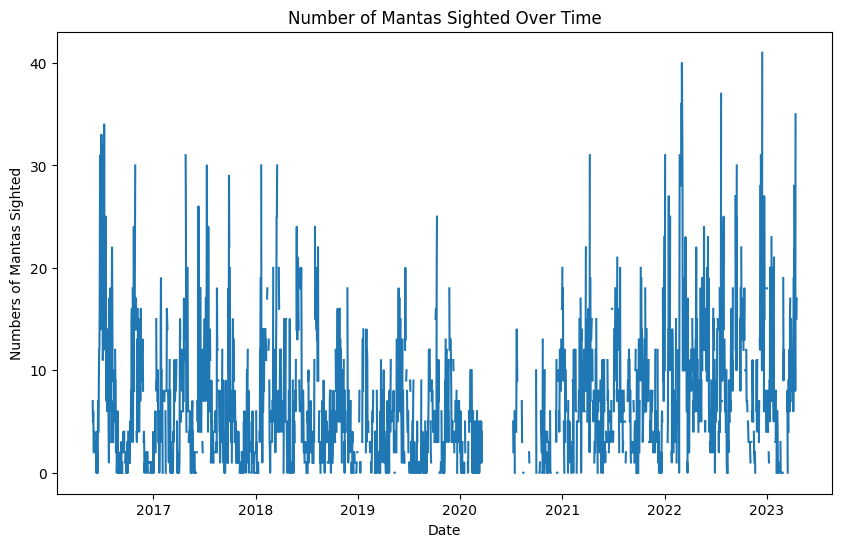

In [17]:
# Create Plot
plt.figure(figsize = (10,6))
plt.plot(df_date_sightings['ds'], df_date_sightings['y'])
plt.ylabel('Numbers of Mantas Sighted')
plt.xlabel('Date')
plt.title('Number of Mantas Sighted Over Time')
plt.show()

What's interesting is the amplitude on the sightings was decreasing towards covid (the empty spot mid 2020 - everyone was closed, we had no trips), and then started increasing again after covid.

## Nulls?

In [18]:
print(f"The total number of rows in the data is: {df_date_sightings['y'].size}")
print(f"The number of nulls in the data is: {df_date_sightings['y'].isna().sum()}")
print(f"Percent null is: {(df_date_sightings['y'].isna().sum()/df_date_sightings['y'].size*100).round(2)}%")

The total number of rows in the data is: 2499
The number of nulls in the data is: 726
Percent null is: 29.05%


For this next analysis we will remove all NaN values. The NaN values correspond to nights that we didn't go out either due to it not being a regularly scheduled night or because of weather conditons. NaNs represent times we didn't have a trip and we just want to see statistics from nights we did. Later we will fill in the missing values for predictive anaylsis.

In [19]:
# Dropping null values
df_sightings_no_null = df_date_sightings.dropna()

## Distribution of Sightings

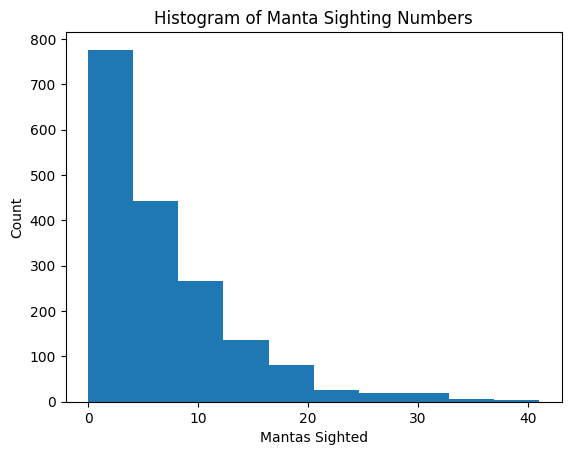

In [20]:
plt.hist(df_sightings_no_null['y'])
plt.xlabel('Mantas Sighted')
plt.ylabel('Count')
plt.title('Histogram of Manta Sighting Numbers')
plt.show()

The graph resembles an exponential distribution. Lets set the bins to intervals of 5 and convert the y-axis to percentage:

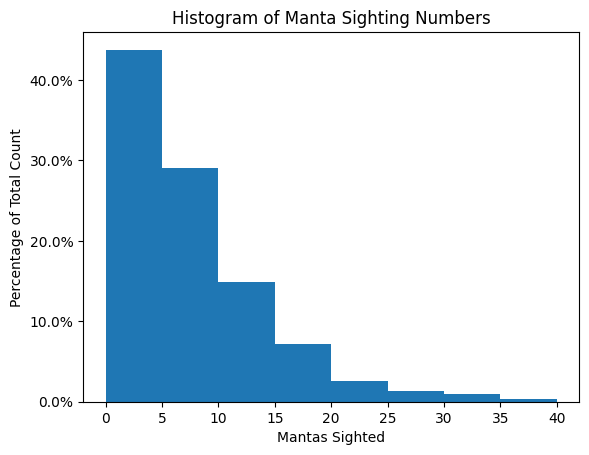

In [21]:
plt.hist(df_sightings_no_null['y'], weights = np.ones(len(df_sightings_no_null['y']))/len(df_sightings_no_null['y']), bins = [0,5,10,15,20,25,30,35,40])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Mantas Sighted')
plt.ylabel('Percentage of Total Count')
plt.title('Histogram of Manta Sighting Numbers')
plt.show()

We can see that about 45% of the time we see between 0 and 5 manta rays. about 30% of the time we see between 5 and 10, 15% of the time we see 10-15, etc.

However, we probably should find out how often we see zero manta rays. Customers do not want to pay money to see nothing, lets find out the likelihood of that occuring.

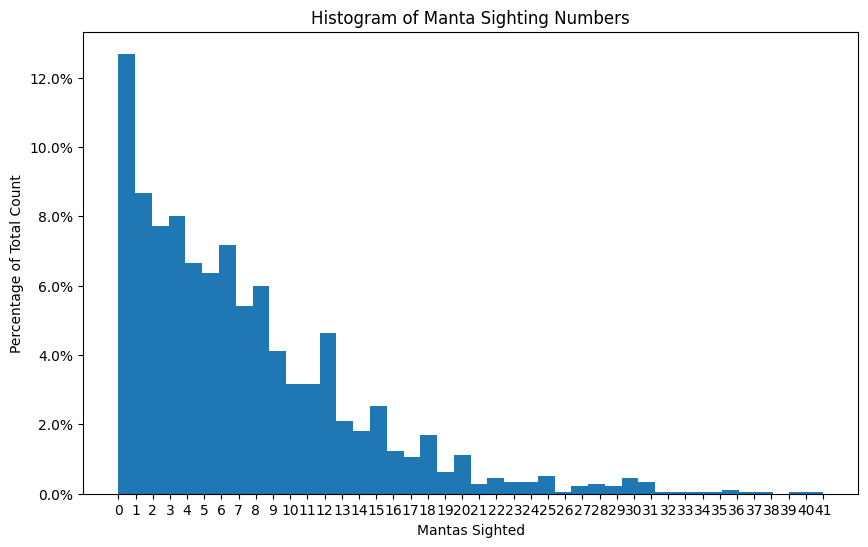

In [22]:
plt.figure(figsize = (10,6))
plt.hist(df_sightings_no_null['y'], weights = np.ones(len(df_sightings_no_null['y']))/len(df_sightings_no_null['y']), bins = int(df_sightings_no_null['y'].max()+1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Mantas Sighted')
plt.rc('xtick', labelsize=3)
plt.xticks(np.arange(min(df_sightings_no_null['y']), max(df_sightings_no_null['y'])+1, 1.0))
plt.ylabel('Percentage of Total Count')
plt.title('Histogram of Manta Sighting Numbers')
plt.show()

In [23]:
no_mantas = df_sightings_no_null[df_sightings_no_null['y'] == 0]['y'].count()/len(df_sightings_no_null)
print(f"The percentage of time we see NO manta rays is: {(no_mantas*100).round(2)}%")

The percentage of time we see NO manta rays is: 12.69%


This is good to know! We don't see mantas about 13%~ of the time. Not great, but that's still approximately a 9/10 chance of seeing manta rays. This also means that about 30% of the time we see between 1-5 mantas.

## Average sightings

In [24]:
print(f"On average we see: {int(df_sightings_no_null.y.mean().round())} manta rays")

On average we see: 7 manta rays


Of course this is just the average, but 7 isn't a bad number. That's a lot of manta rays!

## Average by day of the week

In [25]:
df_sightings_no_null = df_sightings_no_null.copy()
df_sightings_no_null['day_of_week'] = df_sightings_no_null.ds.dt.day_name()

In [26]:
def day_to_num(values):
    if 'Monday' in values:
        return 1
    elif 'Tuesday' in values:
        return 2
    elif 'Wednesday' in values:
        return 3
    elif 'Thursday' in values:
        return 4
    elif 'Friday' in values:
        return 5
    elif 'Saturday' in values:
        return 6
    else:
        return 7

df_sightings_no_null['day_num'] = df_sightings_no_null['day_of_week'].apply(day_to_num)

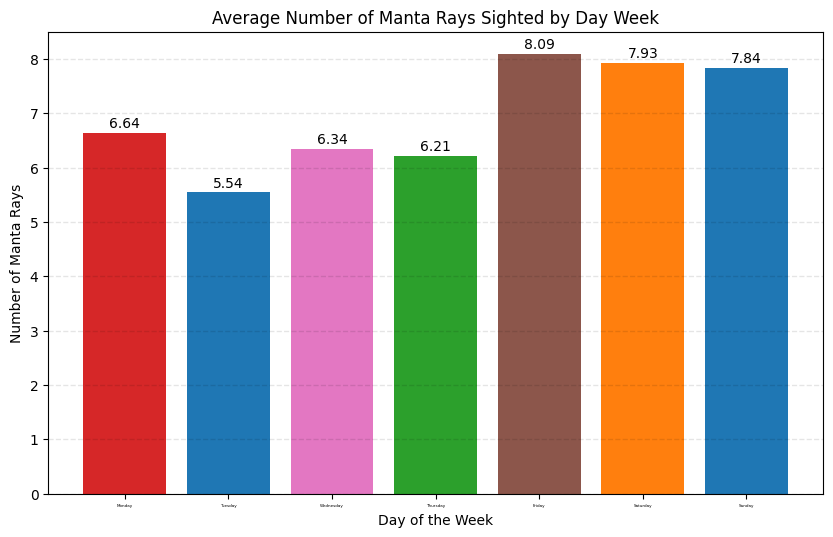

In [27]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+0.1, y[i], ha = 'center')

dof_sightings = pd.DataFrame(data = df_sightings_no_null.groupby('day_num')['y'].mean())
dof_sightings.reset_index(inplace = True)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
dof_sightings['day_num'] = days

bar_colors = ['tab:red', 'tab:blue', 'tab:pink', 'tab:green', 'tab:brown', 'tab:orange', 'tab:blue']

plt.figure(figsize = (10,6))
plt.grid(color='black', linestyle='--', linewidth=1, axis='y', alpha=0.1)
plt.bar(dof_sightings.day_num,dof_sightings['y'], color = bar_colors)
addlabels(dof_sightings.day_num,dof_sightings['y'].round(2))
plt.rc('xtick', labelsize=10)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Manta Rays')
plt.title('Average Number of Manta Rays Sighted by Day Week')

plt.show()

Interestingly, we can see that on weekends there are higher reported numbers than during the week. Given that mantas are wild animals and that this dataset covers many years, there probably shouldn't be a discrepancy like this.

One possible reason is that Keller works on Friday, Sunday, and Monday nights. He can recognize all the manta rays visually and reports a very accurate number. On the other nights crew are reporting an estimate because they don't recognize all the manta rays and are likely undershooting the actual number.

## Dataset Mean and Median

In [28]:
print(f"The sighting average is: {df_sightings_no_null['y'].mean().round(2)}")
print(f"The sighting median is: {df_sightings_no_null['y'].median()}")

The sighting average is: 6.98
The sighting median is: 5.0


This would make sense given the data is heavily skewed to the right.

# Imputing Missing Data

Next we will be doing time series analysis and forecasting. We can't use incomplete data, so we will need to fill in the missing values.

In [29]:
print(f"The total number of rows in the data is: {df_date_sightings['y'].size}")
print(f"The number of nulls in the data is: {df_date_sightings['y'].isna().sum()}")
print(f"Percent null is: {(df_date_sightings['y'].isna().sum()/df_date_sightings['y'].size*100).round(2)}%")

The total number of rows in the data is: 2499
The number of nulls in the data is: 726
Percent null is: 29.05%


Well, almost 30% of the data is null values. That's not great. Next, we will be conducting a time series anaylsis and we can't just drop the nulls. We will need to impute the missing values.

Here's what a subset of the data looks like with the missing values:

In [30]:
subset_plot = df_date_sightings[(df_date_sightings['ds'] >= '2022-01-01') & (df_date_sightings['ds'] < '2023-01-01')]

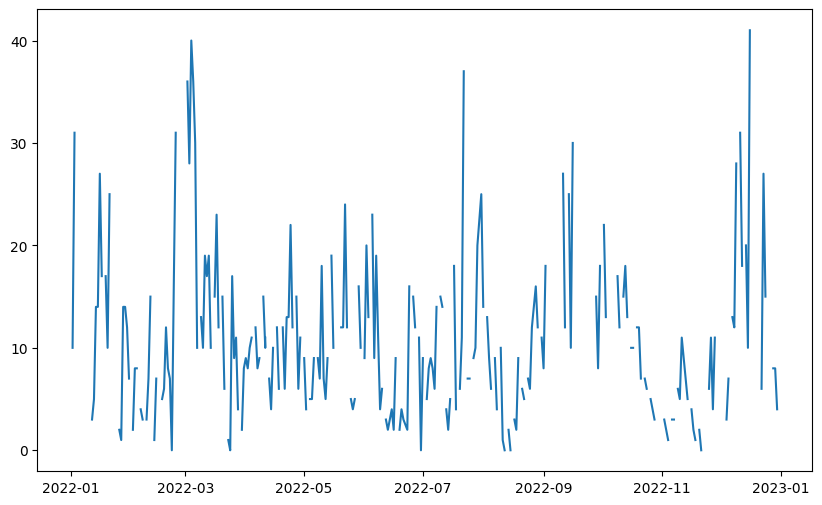

In [31]:
plt.figure(figsize = (10,6))
plt.plot(subset_plot['ds'], subset_plot['y'])
plt.show()

## Linear Interpolation

In [32]:
df_date_sightings['y_linear'] = df_date_sightings['y'].interpolate(method = 'linear')

In [33]:
subset_plot1 = df_date_sightings[(df_date_sightings['ds'] >= '2022-01-01') & (df_date_sightings['ds'] < '2023-01-01')]

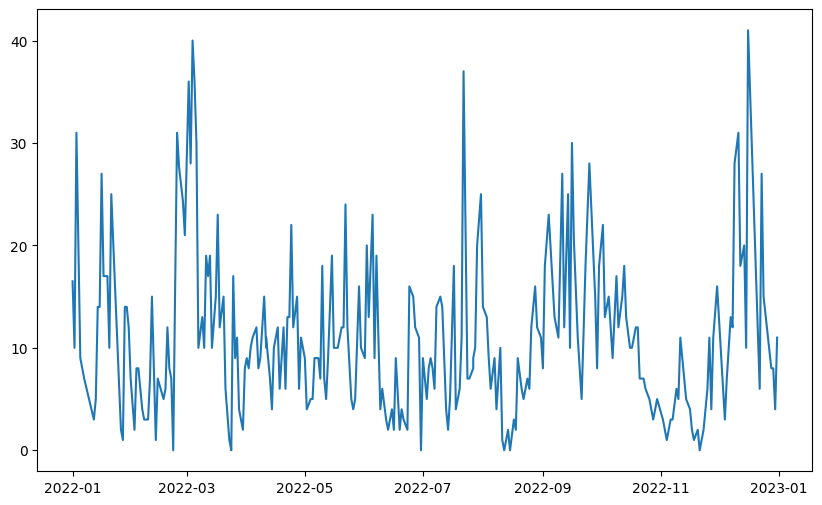

In [34]:
plt.figure(figsize = (10,6))
plt.plot(subset_plot1['ds'], subset_plot1['y_linear'])
plt.show()

## Spline Interpolation

In [35]:
df_date_sightings['y_spline'] = df_date_sightings['y'].interpolate(option = 'spline')

In [36]:
subset_plot2 = df_date_sightings[(df_date_sightings['ds'] >= '2022-01-01') & (df_date_sightings['ds'] < '2023-01-01')]

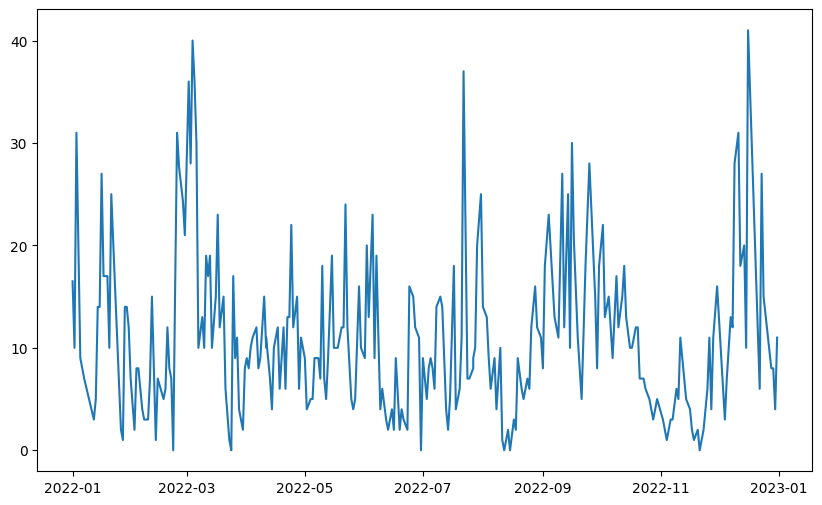

In [37]:
plt.figure(figsize = (10,6))
plt.plot(subset_plot2['ds'], subset_plot2['y_spline'])
plt.show()

In [38]:
df_date_sightings['y_spline'].isna().sum()

0

# Time Series Analysis

## Smoothing

### Moving Averages

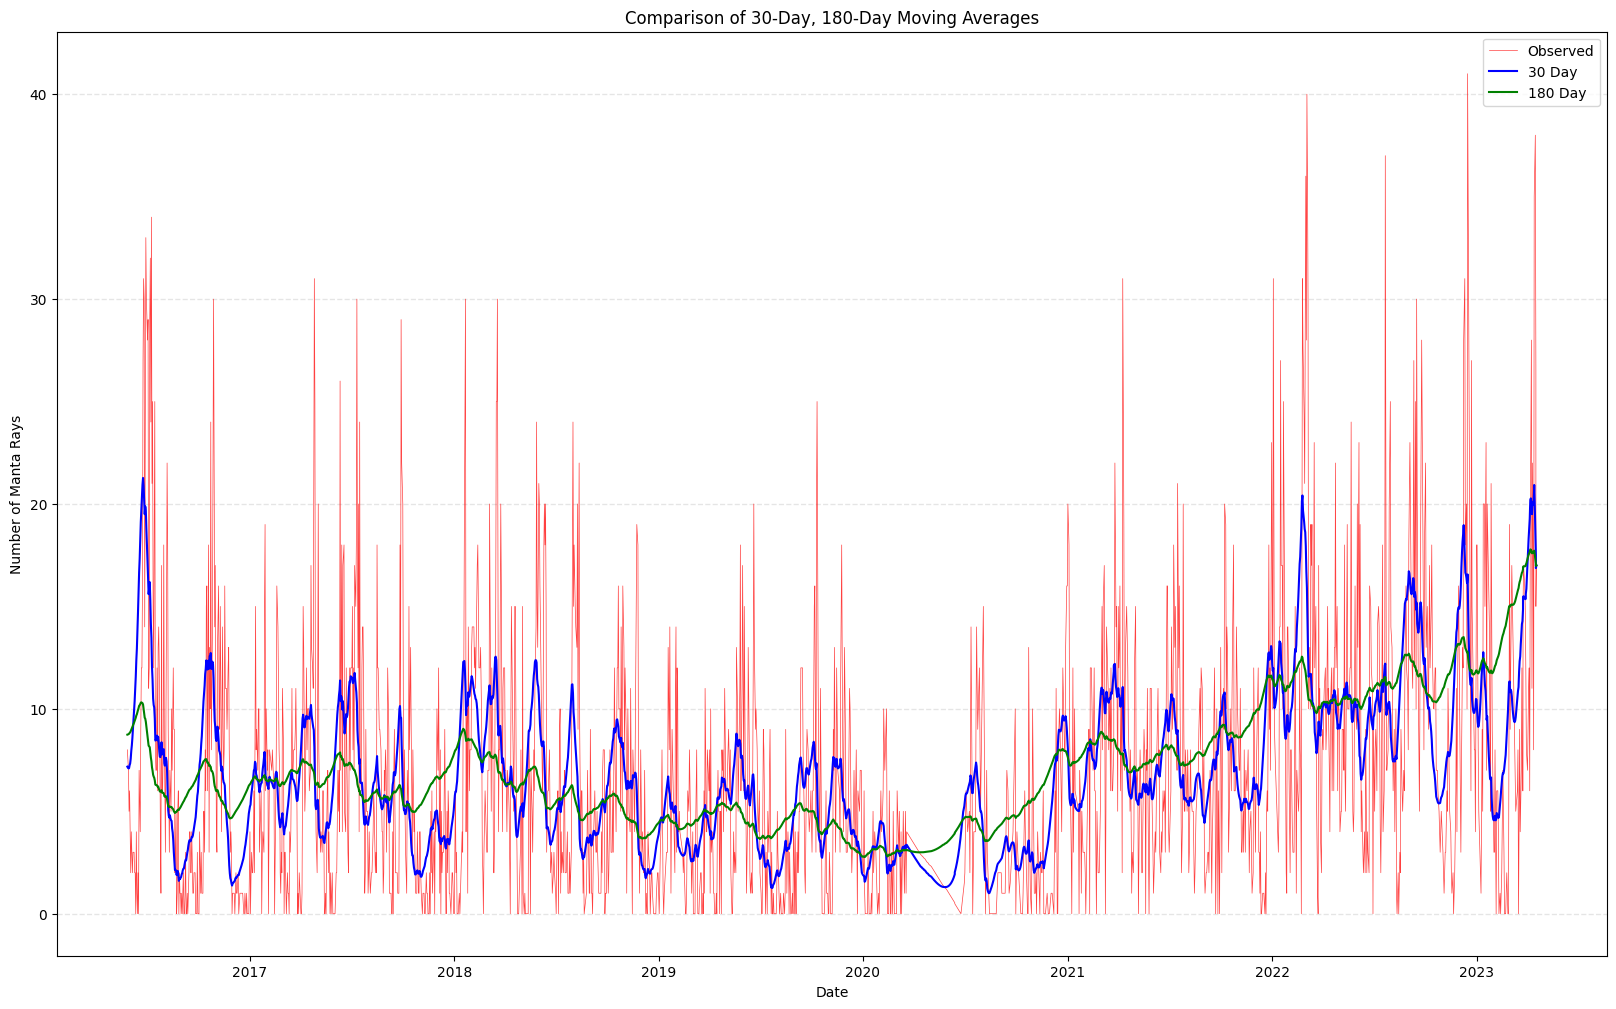

In [39]:
plt.figure(figsize = (20,12))

dates = df_date_sightings.ds.values
observed = df_date_sightings.y_spline.values
EMA_30 = df_date_sightings.y_spline.ewm(span = 30, adjust = False).mean().values
EMA_180 = df_date_sightings.y_spline.ewm(span = 180, adjust = False).mean().values

#Plotting moving averages
plt.plot(dates, observed, color = 'red', linewidth = 0.5, alpha = 0.75, label = 'Observed')
plt.plot(dates, EMA_30, color = 'blue', label = '30 Day')
plt.plot(dates, EMA_180, color = 'green', label = '180 Day')

plt.xlabel('Date')
plt.ylabel('Number of Manta Rays')
plt.title('Comparison of 30-Day, 180-Day Moving Averages')

plt.grid(color='black', linestyle='--', linewidth=1, axis='y', alpha=0.1)

plt.legend()

plt.show()

This moving average graph could have use in the future. If it turns out that forecasting methods don't work well, using moving averages and other stochastic analysis techniques could prove as a viable forecasting option.

### Kalman Filtering

In [40]:
# Create lists of observed values and dates
observations = df_date_sightings.y_spline.values
dates = df_date_sightings.ds.values

# Define the Model
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=observations[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

# Filter on the observations
filtered_states = kf.filter(observations)[0]

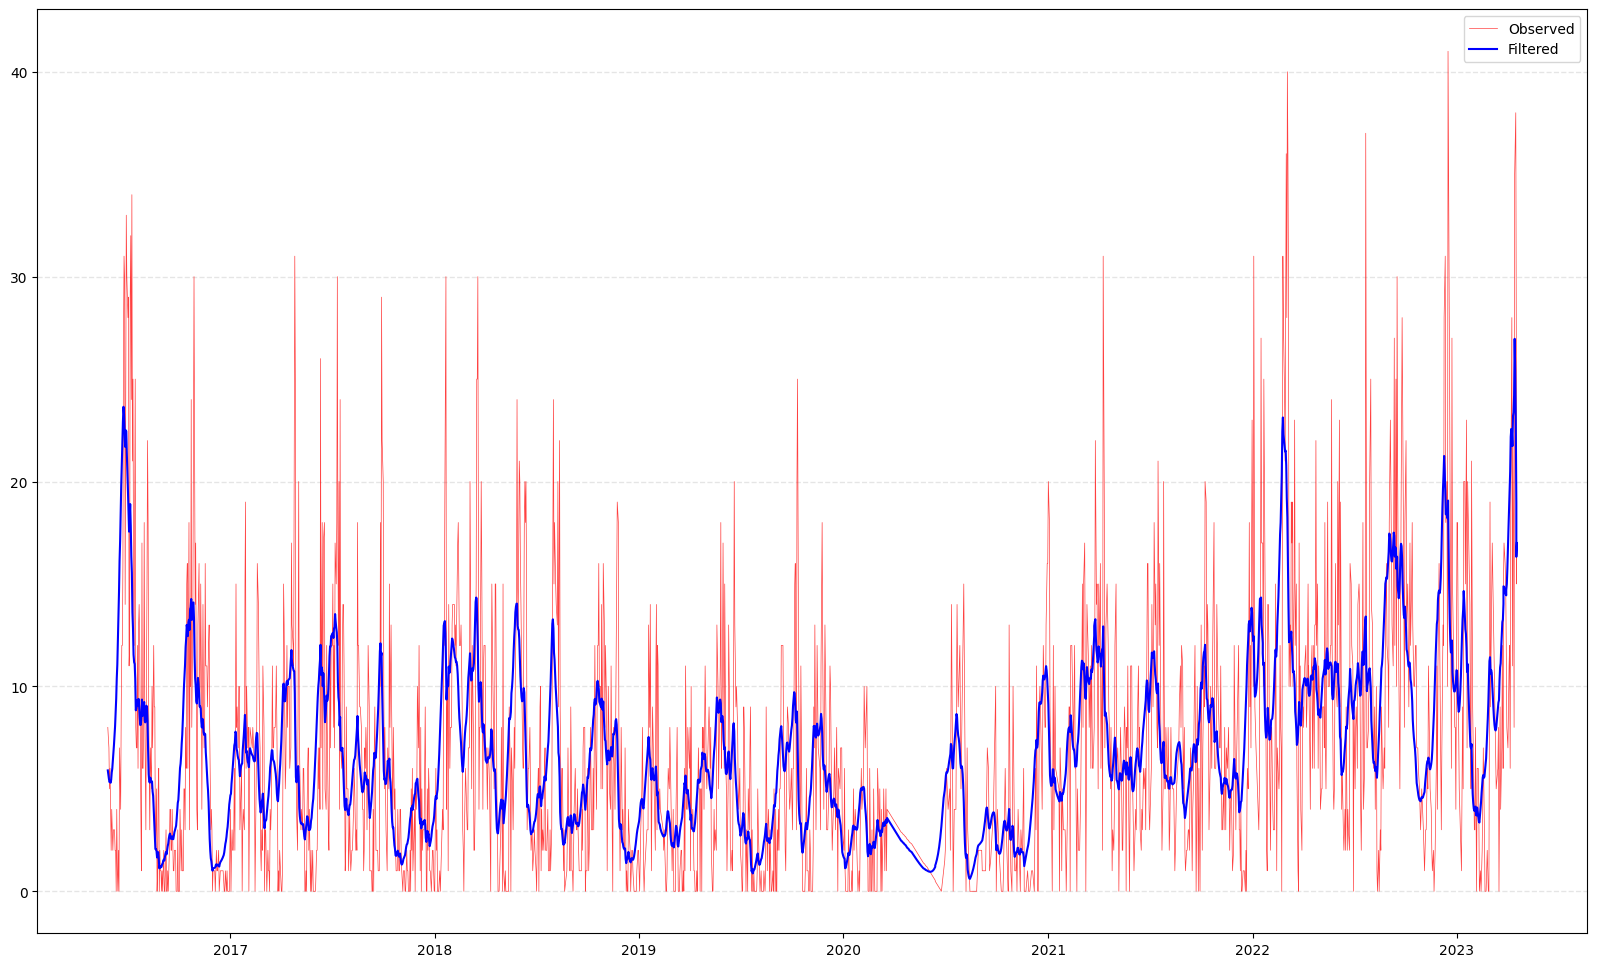

In [41]:
# Plot the Kalman filtering
plt.figure(figsize = (20,12))
plt.plot(dates, observations, color = 'red', linewidth = 0.5, alpha = 0.75, label='Observed')
plt.plot(dates, filtered_states, color = 'blue', label='Filtered')
plt.grid(color='black', linestyle='--', linewidth=1, axis='y', alpha=0.1)
plt.legend()
plt.show()

## Seasonal Decomposition

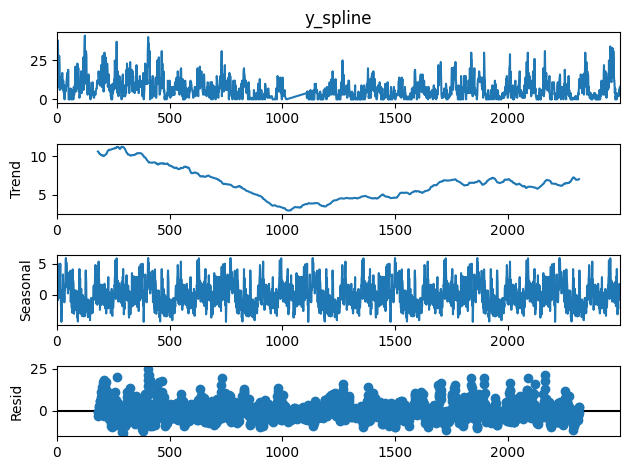

In [42]:
# Run seasonal decomposition
result = seasonal_decompose(df_date_sightings.y_spline, model='additive', period = 365)
result.plot()
plt.show()

## Checking for Stationarity

In [43]:
kpss_stat, p_value, lags, crit = kpss(df_date_sightings.y_spline)

alpha = 0.05

if p_value > alpha:
  print(f"The p-value is :{p_value}, there is stationarity")
else:
  print(f"The p-value is :{p_value}, there is not stationarity")

The p-value is :0.01, there is not stationarity


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## ARIMA Model

### Finding values for p, d, and q

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


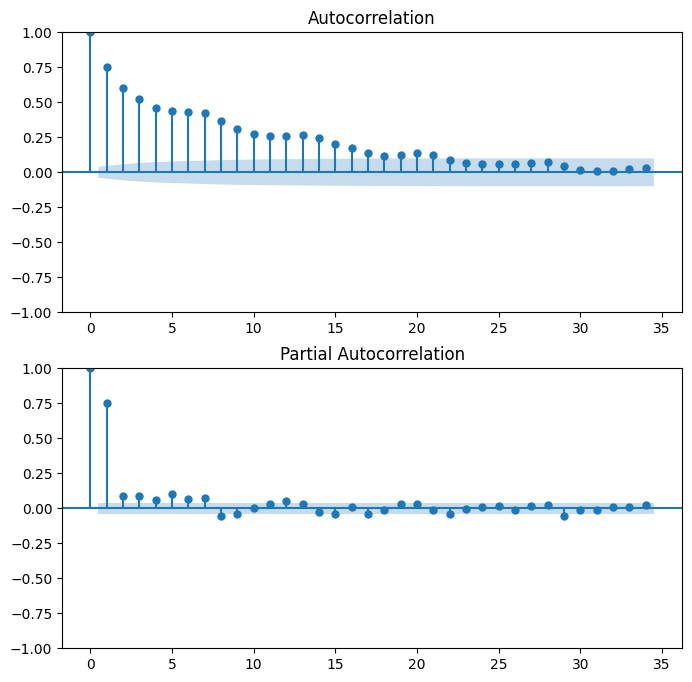

In [44]:
# Create new data frame to feed to plots
d = {'ds': df_date_sightings.ds.values, 'y': df_date_sightings.y_spline.values}
new_df = pd.DataFrame(data=d)
new_df.set_index('ds',inplace = True)

# plot acf and pacf
fig, ax = plt.subplots(nrows=2, figsize=(8, 8))
plot_acf(new_df, ax=ax[0])
plot_pacf(new_df, ax=ax[1])
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-45-48fdb583b1d8>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y'] = (np.array(test_df['y']) * (max_val - min_val)) + min_val

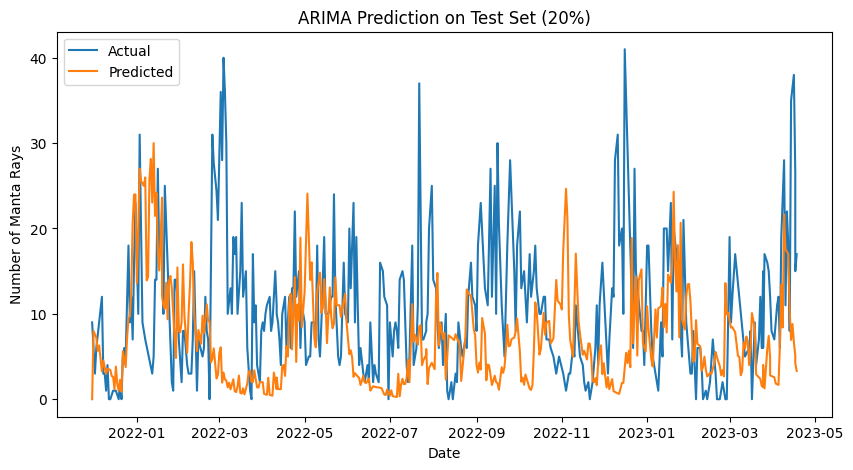

The MAE is: [7.43853272]
The MSE is: 101.33262054347601
The RMSE is: 10.066410509385955


In [45]:
# Create new data set for this model
new_df = pd.DataFrame()
new_df['ds'] = df_date_sightings['ds']
new_df['y'] = df_date_sightings['y_spline']

# Sorting in chronological order
new_df = new_df.sort_values(by='ds', ascending=True)

# Normalize the data
max_val = new_df['y'].max()
min_val = new_df['y'].min()
new_df['y'] = (new_df['y'] - min_val) / (max_val - min_val)

# Split data into training and testing
train_size = int(len(new_df) * 0.8)
train_df = new_df[:train_size]
test_df = new_df[train_size:]

#Determine the value of d using the KPSS test
d = ndiffs(train_df['y'], test='kpss')

#Determine the value of D using the seasonal OCSB test
D = nsdiffs(train_df['y'], m=12, test='ocsb')

# Determine the values of p and q using auto_arima function from pmdarima library
#model = auto_arima(train_df['y'], seasonal=True, m=12, d=d, D=D, trace=True, error_action='ignore', suppress_warnings=True)
# Best model:  ARIMA(1,1,1)(0,0,0)[12]

#p, q = model.order[0], model.order[2]
p, q = 1, 1

# Fit the ARIMA model
arima_model = ARIMA(train_df['y'], order=(p, d, q)).fit()

# Generate predictions on test set
predictions = arima_model.predict(start=test_df.index.min(), end=test_df.index.max(), typ='levels')

# Convert data back to original scale
predictions = (np.array(predictions) * (max_val - min_val)) + min_val
test_df['y'] = (np.array(test_df['y']) * (max_val - min_val)) + min_val

# Plot the original data vs the predictions
plt.figure(figsize = (10,5))
plt.plot(test_df['ds'], test_df['y'], label = 'Actual')
plt.plot(test_df['ds'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Manta Rays')
plt.title('ARIMA Prediction on Test Set (20%)')
plt.legend()
plt.show()

# Calculate and print out accuracy measures
mae = mean_absolute_error(test_df['y'],predictions,multioutput='raw_values')
mse = mean_squared_error(test_df['y'],predictions)
print(f"The MAE is: {mae}")
print(f"The MSE is: {mse}")
print(f"The RMSE is: {sqrt(mse)}")

## LSTM Model

Epoch 0 loss: 0.04850032553076744
Epoch 1 loss: 0.04752452298998833
Epoch 2 loss: 0.04782899469137192
Epoch 3 loss: 0.047915004193782806
Epoch 4 loss: 0.047906357795000076
Epoch 5 loss: 0.04787329211831093
Epoch 6 loss: 0.04785819351673126
Epoch 7 loss: 0.04787742719054222
Epoch 8 loss: 0.04793551564216614
Epoch 9 loss: 0.04802820086479187
Epoch 10 loss: 0.04814706742763519
Epoch 11 loss: 0.048283450305461884
Epoch 12 loss: 0.048430074006319046
Epoch 13 loss: 0.04858129844069481
Epoch 14 loss: 0.048733342438936234
Epoch 15 loss: 0.048883773386478424
Epoch 16 loss: 0.04903100058436394
Epoch 17 loss: 0.049174122512340546
Epoch 18 loss: 0.04931254684925079
Epoch 19 loss: 0.0494459830224514
Epoch 20 loss: 0.049574218690395355
Epoch 21 loss: 0.04969722032546997
Epoch 22 loss: 0.04981489107012749
Epoch 23 loss: 0.04992726817727089
Epoch 24 loss: 0.050034429877996445
Epoch 25 loss: 0.05013642460107803
Epoch 26 loss: 0.05023329704999924
Epoch 27 loss: 0.05032506212592125
Epoch 28 loss: 0.05041

<ipython-input-46-a8f412e6a464>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y'] = (np.array(test_df['y']) * (max_val - min_val)) + min_val


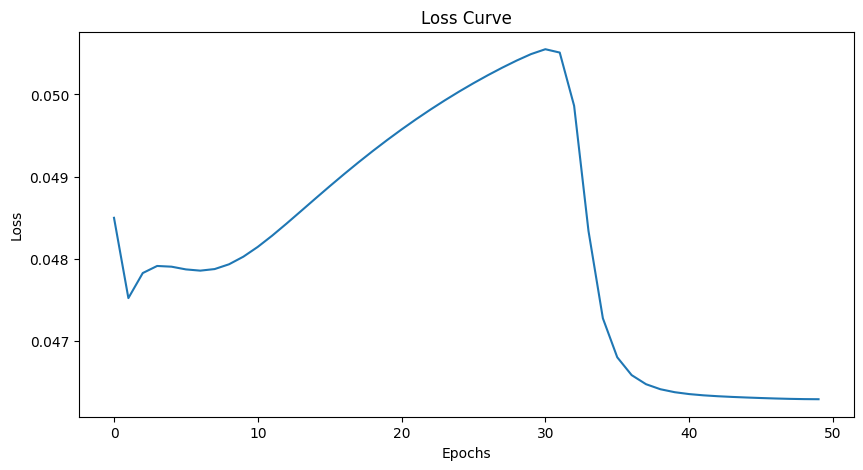

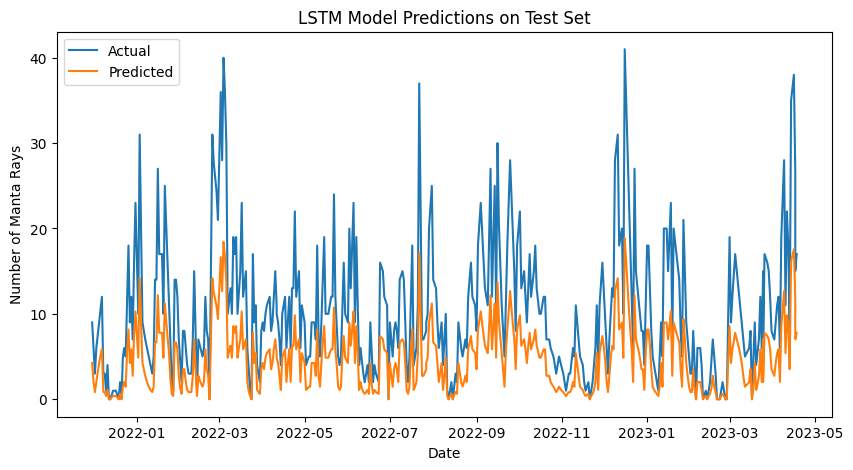

The MAE is: [5.89184955]
The MSE is: 51.02185327934871
The RMSE is: 7.142958300266684


In [46]:
# Set random seed
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

seed_value = 42
set_seed(seed_value)

# Create new data set for model to predict on
new_df = pd.DataFrame()
new_df['ds'] = df_date_sightings['ds']
new_df['y'] = df_date_sightings['y_spline']

# Sorting in chronological order
new_df = new_df.sort_values(by='ds', ascending=True)

# Normalize the data
max_val = new_df['y'].max()
min_val = new_df['y'].min()
new_df['y'] = (new_df['y'] - min_val) / (max_val - min_val)

# Split the data into train and test sets
train_size = int(len(new_df) * 0.8)
train_df = new_df[:train_size]
test_df = new_df[train_size:]

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        predictions = self.fc(lstm_out.view(len(input), -1))
        return predictions[-1]

# Set the hyperparameters for the model
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.01
num_epochs = 50
epochs = []
losses = []

# Create the model and define the loss function and optimizer
model = LSTM(input_size, hidden_size, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i in range(len(train_df) - 1):
      x = torch.Tensor(train_df['y'][i:i+1].values)
      y = torch.Tensor(train_df['y'][i+1:i+2].values)
        
      optimizer.zero_grad()
      output = model(x)
      loss = loss_function(output, y)
      loss.backward()
      optimizer.step()
    with torch.no_grad():
      epochs.append(epoch)
      losses.append(loss)
      print(f"Epoch {epoch} loss: {loss}")

# Graph loss curve
plt.figure(figsize = (10,5))
with torch.no_grad():
  plt.plot(epochs,losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show

# Make predictions on the test set
test_inputs = torch.Tensor(test_df['y'].values)
test_predictions = []

for i in range(len(test_inputs)):
    input = test_inputs[i:i+1]
    output = model(input)
    test_predictions.append(output.detach().numpy().flatten()[0])

# Convert data back to original scale
test_predictions = (np.array(test_predictions) * (max_val - min_val)) + min_val
test_df['y'] = (np.array(test_df['y']) * (max_val - min_val)) + min_val

# Shifting test predictions back to a min value of zero
# For some reason after converting, the min for the predictions kept coming out to below zero
test_predictions = test_predictions-test_predictions.min()

# Plot the actual values vs the predicted values
plt.figure(figsize = (10,5))
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(test_df['ds'], test_predictions, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Manta Rays')
plt.title('LSTM Model Predictions on Test Set')
plt.show()

# Calculate and print out accuracy measures
mae = mean_absolute_error(test_df['y'],test_predictions, multioutput='raw_values')
mse = mean_squared_error(test_df['y'],test_predictions)
print(f"The MAE is: {mae}")
print(f"The MSE is: {mse}")
print(f"The RMSE is: {sqrt(mse)}")

This model predicts the best so far! The MAE is only 5~, which means on average we can expect the model to be about 5 mantas off.

To me it looks like the model captures the noise really well. However, it doesnt cover the full amplitude of the spikes. I wonder if multiplying the predicted values by a scalar component would increase the accuracy?

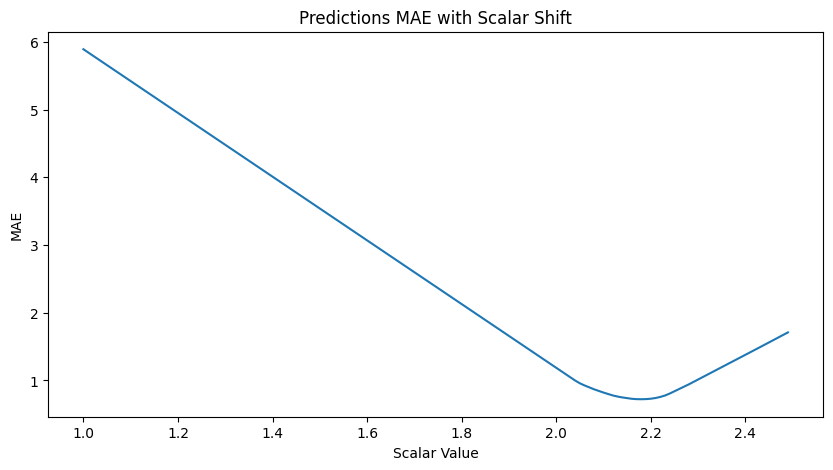

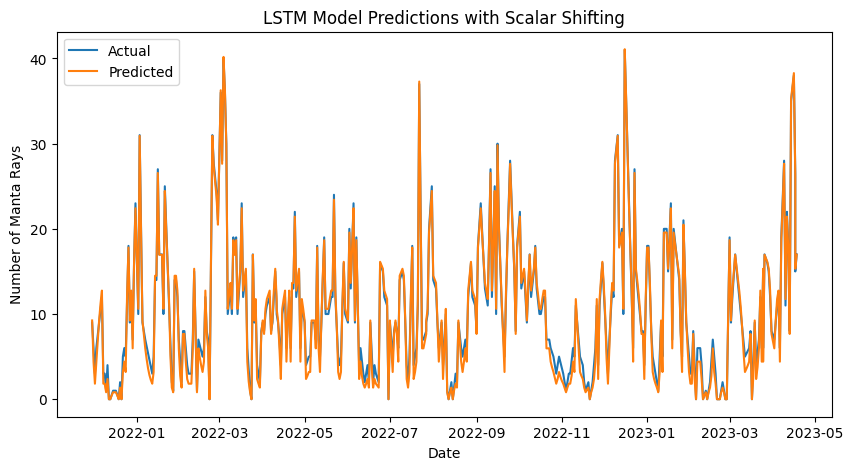

Scalar: [2.18]
The MAE is: [0.72264541]
The MSE is: 0.8175788367275885
The RMSE is: 0.9042006617602026


In [47]:
# Create list of scalars to multiply predictions by
vals = np.arange(1.0, 2.5, 0.01).tolist()
mae = []

# Calculate range of MAEs
for i in vals:
  preds = test_predictions*i
  [ma] = mean_absolute_error(test_df['y'],preds, multioutput='raw_values')
  mae.append(ma)

# Append to new dataframe
scalars = pd.DataFrame()
scalars['scalar'] = vals
scalars['MAE'] = mae

# Plot findings
plt.figure(figsize = (10,5))
plt.plot(scalars['scalar'], scalars['MAE'])
plt.xlabel('Scalar Value')
plt.ylabel('MAE')
plt.title('Predictions MAE with Scalar Shift')
plt.show()

# Find the scalar that corresponds to lowest MAE
min_scalar = scalars[scalars.MAE == scalars.MAE.min()]['scalar'].values

# Shift predictions by scalar
preds_adj = test_predictions * min_scalar

# Plot the actual values vs the predicted values
plt.figure(figsize = (10,5))
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(test_df['ds'], preds_adj, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Manta Rays')
plt.title('LSTM Model Predictions with Scalar Shifting')
plt.show()

# Calculate and print out accuracy measures
mae = mean_absolute_error(test_df['y'],preds_adj, multioutput='raw_values')
mse = mean_squared_error(test_df['y'],preds_adj)
print(f"Scalar: {min_scalar}")
print(f"The MAE is: {mae}")
print(f"The MSE is: {mse}")
print(f"The RMSE is: {sqrt(mse)}")

Here we can see that by multiplying the predicted values by a scalar of 2.0 the accuracy of the predictions went up. With this model we can expact the average error of our predictions to be off by half a manta ray.

I'm not sure if this is best practice. I'm sure anyone could take the output of models and tweak it until the model has perfect accuracy. This just made sense to me. If this model is ever deployed to predict manta sightings, the scalar value would need to be updated periodically as new data was collected.

Alternatively, I could not use the scalar multiplication at all. The model captures whatever pattern is happening in the data very well. If anything it undershoots sighting predictions, which isn't a bad thing. It would lead to customers being pleasantly surprised.

## Meta Prophet

This forecasting model is Meta's Prophet Package. It automatically fits to data, but allows some tweaking.

In [48]:
# Create new data set for model to predict on
new_df = pd.DataFrame()
new_df['ds'] = df_date_sightings['ds']
new_df['y'] = df_date_sightings['y_spline']

# Build model and fit to data
m = Prophet()
#changepoint_prior_scale=0.5, seasonality_prior_scale=0.5
m.fit(new_df)

# Create forecast
future = m.make_future_dataframe(periods=int(len(new_df) * 0.2))
forecast = m.predict(future)

'''
# Plot forecast
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig1.legend()
fig2 = m.plot_components(forecast)
'''

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphcx51k9_/gtmahpin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphcx51k9_/r40l4w6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75589', 'data', 'file=/tmp/tmphcx51k9_/gtmahpin.json', 'init=/tmp/tmphcx51k9_/r40l4w6z.json', 'output', 'file=/tmp/tmphcx51k9_/prophet_modelfwigqh1k/prophet_model-20230420194434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


'\n# Plot forecast\nfig1 = m.plot(forecast)\na = add_changepoints_to_plot(fig1.gca(), m, forecast)\nfig1.legend()\nfig2 = m.plot_components(forecast)\n'

In [49]:
# Plot forecast using plotly
plot_plotly(m, forecast)

In [50]:
# Print model components
plot_components_plotly(m, forecast)

In [51]:
# Disable the logger
import logging
logging.getLogger('prophet').disabled = True

# Evaluate model performance
df_cv = cross_validation(m,
                     horizon='7 days',
                     period='180 days',
                     initial='730 days')
df_p = performance_metrics(df_cv)
print(f"\n\nBest horizon: \n{df_p[df_p['mae'] == df_p['mae'].min()]}")

  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmphcx51k9_/16u5p2wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphcx51k9_/zoi51_oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20820', 'data', 'file=/tmp/tmphcx51k9_/16u5p2wf.json', 'init=/tmp/tmphcx51k9_/zoi51_oz.json', 'output', 'file=/tmp/tmphcx51k9_/prophet_model55s807eq/prophet_model-20230420194436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphcx51k9_/m50vt1c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphcx51k9_/_ukais_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l



Best horizon: 
  horizon       mse      rmse       mae     mdape     smape  coverage
0  1 days  7.616723  2.759841  2.398394  0.236777  0.399265       1.0


This model has similar performace to the LSTM model above. However, I think it's calcualting the coverage to be all points within the upper and lower bounds of the forecast.

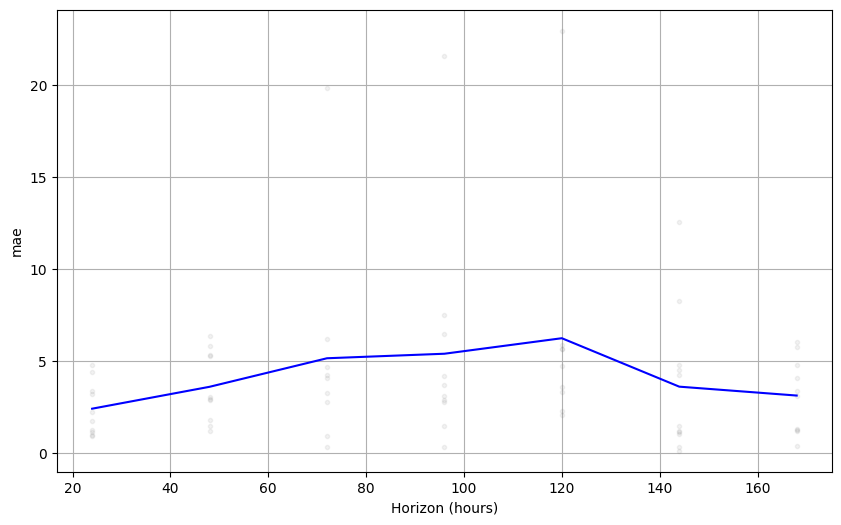

In [52]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Results and Insights

### Sightings:
1. Sightings follow an exponential distribution. About 13% of the time we see 0 rays, 9% of the time we see 1, and so on and so fourth with increased sighting counts tapering down. (See the Distribution of Sightings section for more info).
2. On average we see 7 manta rays. It varies by day of the week. I doubt that the actual average number of mantas varies, however I think the reported average varies. I think there's some human error with the reporting.
3. The 6-month moving average decreased from 10 in mid 2016 to 4 right before the covid pandemic. It since then rose from around 4 back to over 10.

### Predictions:
1. Moving averages and other stochastics analysis techniques may be a good way of forecasting future sighting counts.
2. The ARIMA model did not predict well on the data. The MAE was around 7, indicating that on average the model predicted off by 7 mantas.
3. The LSTM model predicted the best. When stretching prediction by a scalar value, the model had a mean absolute error of 0.5. I would hesitate to deploy this model for forecasting. I expect that I may have implmented the model wrong because of the ridiculuously high accuracy on such noisy data.
4. Meta's Prophet worked well on the data. If implemented in certain ways if could be a good range predictor of manta sighting counts.

# Thoughts for future analysis

Other data sources are available to conduct further analysis. Two sources I think may be beneficial are OpenWeatherMap and the PacIOOS. OpenWeatherMap has an API that can call historical and forecasted atmospheric weather data. PacIOOS is an ocean current forecasting and prediction model that includes the islands of Hawaii, it also has a callable Python API. It could be used to view ocean current, tide, water temp, salinity, etc. The two sources could be used to isolate variables that weigh heavily to sighting counts.

Using these two sources, regression analysis could be conducted to find variables that correlate to manta sighting counts. The analysis of atmospheric and oceanic weather data could help us determine, at least correlationally, what affects manta counts on the manta ray night dive.